# Introduction to Dense Deep Neural Network for Temperature regression using satellite based land surface temperature.

In this exercise, we introduce dense neural network layers for regression. We also provide an example of modeling using spatial datasets. We predict monthly air temperature using satellite based measurements of Land Surface Temperature (LST) from the MODIS sensor. The goal is to use the relationship between satellite and ground temperature meteorological stations measurements within a regression model. The ground temperature measurements were obtained from the Global Historical Climate Network (GHCN). To test the relationship, we predict air temperature for the month of January and July 2010 using MODIS raster layers. The MODIS layers are pre-processed monthly long term averages over the 2001-2012 time period. 


Interesting links:

- modis data: https://terra.nasa.gov/about/terra-instruments/modis

- tensorflow regression: https://www.tensorflow.org/tutorials/keras/regression


# Set up google colab environment and load libraries

In [ ]:
try: # try the following block of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd
  
try:
  import contextily as ctx # import
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
import contextily as ctx # library for providing background maps
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon
!pip install rasterio
!pip install pyproj
#https://colab.research.google.com/github/bwsi-hadr/03-Intro-to-GIS/blob/master/03_Intro_to_GIS.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
###### Library used in this script
#general use python packages and packages for data processing/visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import subprocess
import pandas as pd
import os, glob

#python packages related to geospatial data
from rasterio import plot
import geopandas as gpd
from osgeo import gdal
import rasterio
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict

# modeling packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Deep learning packages
#import keras
#from keras.models import Sequential
#from keras.layers import *

#Keras import
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
#from keras.optimizers import Adam
from keras import layers
#from keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
#from tensolayers.Dense import Dense

# Functions
In the next part of the script, we declare all the functions used in the sripts. It is good practice to place functions at the beginning of a script or in an external source file. Here are the functions used:

- create_dir_and_check_existence: create and output directory given a path. The output directory will be the working directory throughout the analysis.

- model_predict_assessment: This function fits and predicts based on a input model (keras or sklearn) given a set of inputs. It also generates accuracy metrics to evaluate the performance.


In [ ]:
################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

def model_predict_assessement(model,
                              data_df,
                              selected_features,
                              selected_target,
                              prop=0.3,
                              random_seed=100,
                              epoch_val=None,
                              out_dir='.'):

    '''
    This function fits and predicts based on a input model (keras or sklearn) given a set of inputs. It also generates accuracy metrics to evaluate the performance.
    
    Input Arguments:

    model: a sklearn or keras model
    data_df: input data frame with relevant columns including features and target
    selected_features: set of input features to consider for the model (list from the data.frame)
    selected_target: selected target feature from the data.frame
    prop: proportion of input data.frame to keep for testing/holdout  
    random_seed: seed to use for reproducibility
    epoch_val: number of epoch to run the keras model, if None then it is assumed that the model is a sklearn model.
    out_dir: output directory

    Return Outputs:

    data_metrics_df: data.frame with columns including accuracy metrics (MAE, RMSE), months and model name used
    '''
    
    ##### Train/test split

    X_train, X_test, y_train, y_test = train_test_split(data_df[selected_features], 
                                                    data_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
    
    ############## Rescale inputs ######## 

    #### Scaling between 0-1 for continuous variables
    selected_continuous_var_names = selected_features
    # Data needs to be scaled to a small range like 0 to 1 for the neural
    # network to work well.
    scaler = MinMaxScaler(feature_range=(0, 1))
    ### need to select only the continuous var:
    scaled_training = scaler.fit_transform(X_train[selected_continuous_var_names])
    scaled_testing = scaler.transform(X_test[selected_continuous_var_names])

    ## Concatenate column-wise
    X_testing_df = pd.DataFrame(scaled_testing,columns=selected_continuous_var_names)
    X_training_df = pd.DataFrame(scaled_training, columns=selected_continuous_var_names)
    X_testing_df.to_csv(os.path.join(out_dir,
                    "X_testing_df_"+out_suffix+".csv"))
    X_training_df.to_csv(os.path.join(out_dir,
                    "X_training_df_"+out_suffix+".csv"))

    X = X_training_df.values
    Y = y_train #.values
    
    ############## Fit and predict model
    
    if(epoch_val is not None):
      history1_validation = model.fit(
                                     X,
                                     Y,
                                epochs=epoch_val,
      )
    else:
      model.fit(X, Y)

    y_pred_train = model.predict(X) # Note this is a fit!
    y_pred_test = model.predict(X_testing_df) # Note this is a test

    ########### Accuracy Assessment #######

    #from sklearn import metrics 

    mae_val_test = metrics.mean_absolute_error(y_test, y_pred_test) #MAE test
    rmse_val_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)) #RMSE test
    mae_val_train = metrics.mean_absolute_error(y_train, y_pred_train) #MAE train
    rmse_val_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)) #RMSE train
    
    data = np.array([[mae_val_test,rmse_val_test],
                     [mae_val_train,rmse_val_train]])
    data_metrics_df = pd.DataFrame(data,columns=['mae','rmse'])
    data_metrics_df['test']=[1,0]
        
    return data_metrics_df


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [ ]:
############################################################################
#####  Parameters and argument set up ###########

#ARGS 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_dense_neural_network/data/'

#ARGS 2
out_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_dense_neural_network/'

#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "DNN_20230314" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # NA flag value
#ARG 6
ghcn_filename = "ghcn_or_tmax_covariates_06262012_OR83M.shp" # climate stations
#ARG 7
prop = 0.3
#ARG 8
random_seed= 42
#ARGS 9
#epsg 2991
crs_reg = "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
#ARGS 10
infile_lst_month1 = "lst_mean_month1_rescaled.tif" 
#ARGS 11
infile_lst_month7 = "lst_mean_month7_rescaled.tif" 
#ARGS 12
epoch_n = 600

# Create output directory 

In [ ]:
################# START SCRIPT ###############################
######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [ ]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_dense_neural_network/outputs/output_data_DNN_20230314


# Workflow/pipeline

There are multiple steps:
1. **Data Visualization and exploration** 
- Explore Land Surface Temperature and the meteorological stations provided
2. **Extraction of LST values from raster**
- Extract LST values for January and July using station point locations.
3. **Processing stations data and LST**
- Process stations data and LST values extract. This includes removing NAs and rescaling to Celsius degree units.
4. **Feature selection and feature processing**
- select input features and target
- rescale input features between 0-1
- train-test split/hold out
5. **Building and training models**
- build baseline model with Linear Regression model in sklearn
- build dense neural network keras model
- train models using training data
6. **Accuracy Assessment**
- quick comparison
- compare models and predict for July and January
7. **Conclusions**


# 1 Data visualization and exploration

We visualize the remotely sensed LST images and the locations of meteorological stations within the Oregon study area. We use rasterio and geopandas to read in data in raster and shapefile formats respectively.

In [ ]:
###########################################
### PART I: READ AND VISUALIZE DATA #######

data_gpd = gpd.read_file(os.path.join(in_dir,ghcn_filename)) 

## Extracting information from raster using raster io object
lst1 = rasterio.open(os.path.join(in_dir,infile_lst_month1))
lst7 = rasterio.open(os.path.join(in_dir,infile_lst_month7))
print(type(lst1))
print("Coordinate reference system: ",lst1.crs ) 
print(" Rows and columns: ", lst1.shape, "number of rows: ", lst1.height)  
data_gpd.head() 
               

<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  EPSG:2991
 Rows and columns:  (536, 745) number of rows:  536


,station,year,month,day,element,value,mflag,qflag,sflag,lat,...,mmv_05,mmv_06,mmv_07,mmv_08,mmv_09,mmv_10,mmv_11,mmv_12,date,geometry
0,USC00350036,2010,1,1,TMAX,-9999,NaN,NaN,NaN,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100101,POINT (449915.447 47537.726)
1,USC00350036,2010,2,1,TMAX,61,0,NaN,NaN,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100201,POINT (449915.447 47537.726)
2,USC00350036,2010,3,1,TMAX,122,0,NaN,NaN,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100301,POINT (449915.447 47537.726)
3,USC00350036,2010,4,1,TMAX,44,0,NaN,NaN,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100401,POINT (449915.447 47537.726)
4,USC00350036,2010,5,1,TMAX,-9999,NaN,NaN,NaN,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100501,POINT (449915.447 47537.726)


It's also useful to get all the metadata information using the method profile or meta from the rasterio DatasetReader class. It returns a dictionary.

In [ ]:
print(type(lst1))
lst1.meta

<class 'rasterio.io.DatasetReader'>


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 745,
 'height': 536,
 'count': 1,
 'crs': CRS.from_epsg(2991),
 'transform': Affine(926.5901740771812, 0.0, 33936.6328125,
        0.0, -926.8062142899254, 519942.84375)}

<AxesSubplot:title={'center':'LST July'}>

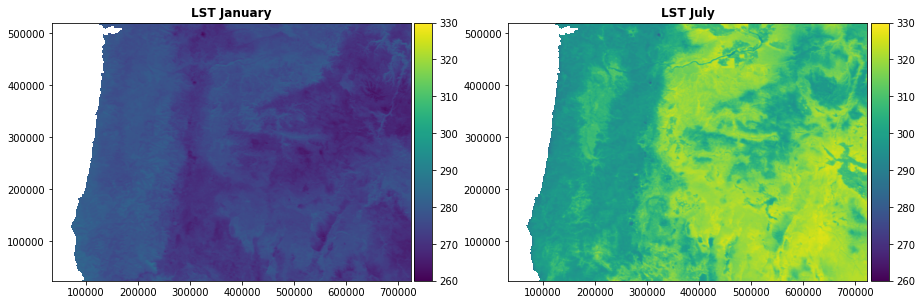

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(1, 2,figsize=(15,15))
image_hidden1 = ax[0].imshow(lst1.read()[0],clim=(260,330))
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
f.colorbar(image_hidden1, ax=ax[0],cax=cax1)
plot.show(lst1,title="LST January",clim=(260,330),ax=ax[0])


image_hidden2 = ax[1].imshow(lst7.read()[0],clim=(260,330))
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
f.colorbar(image_hidden2, ax=ax[1],cax=cax2)
plot.show(lst7,title="LST July",clim=(260,330),ax=ax[1])

#Interesting links to look at:
#https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
#https://courses.spatialthoughts.com/python-dataviz.html
#https://sigon.gitlab.io/post/2018-11-08-plot-raster-nodata-values/
#http://patrickgray.me/open-geo-tutorial/chapter_3_visualization.html
#https://geobgu.xyz/py/rasterio.html#summarizing-values

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:title={'center':'Combine raster and points in a plot'}>

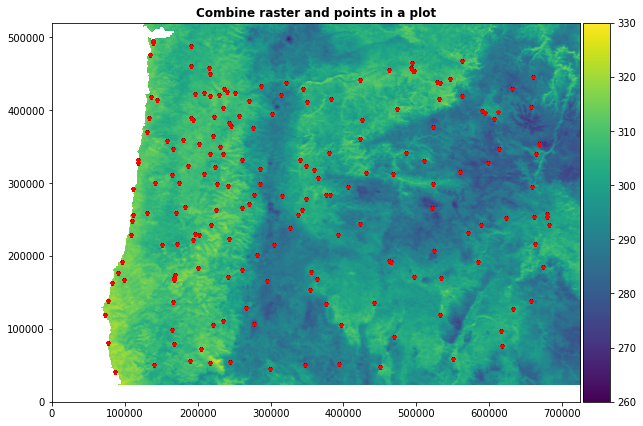

In [ ]:
##### Combine raster layer and geogpanda layer

station_or = data_gpd.to_crs({'init': 'epsg:2991'}) #reproject to  match the  raster image

##### How to combine plots with rasterio package
fig, ax = plt.subplots(figsize=(10,10))
image_hidden1 = ax.imshow(lst1.read()[0],clim=(260,330))
divider = make_axes_locatable(ax) #necessary if figsize is set and it doesn't use the image ratio
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(image_hidden1, ax=ax,cax=cax)
rasterio.plot.show(lst1,ax=ax,
                          clim=(259.0,287.0),
                  title="Combine raster and points in a plot")
station_or.plot(ax=ax,
                marker="*",
                color="red",
                markersize=10)

# 2 Extraction of LST values from raster

Using meteorological station locations, we extract LST values using rasterio function 'sample' for the month of January and July. This requires an iterator with x,y coordinates matching the coordinate reference systems in the raster image.

In [ ]:
#### Extract information from raster using coordinates
x_coord = station_or.geometry.x # pands.core.series.Series
y_coord = station_or.geometry.y
coords = [(x,y) for x, y in zip(x_coord, y_coord)]
print(type(coords))

station_or['LST1_val']= np.asarray([val for val in lst1.sample(xy=coords)])
station_or['LST7_val']= np.asarray([val for val in lst7.sample(xy=coords)])

station_or[['LST1_val','LST7_val']].head()

<class 'list'>


,LST1_val,LST7_val
0,280.020691,318.788666
1,280.020691,318.788666
2,280.020691,318.788666
3,280.020691,318.788666
4,280.020691,318.788666


# 3 Processing stations data and LST

The values extracted are in Kelvin degree and are repeated in each row. We convert values in degree C, and remove no data values (flag value is -9999). We compute averages at each weather station using the "groupby" pandas operator.The goal is to generate unique monthly LST values for each station. Note that we also need to rescale the GHCN network values to have comparable LST and ground measurements.

In [ ]:
print("number of rows:",station_or.station.count(),", number of stations:",len(station_or.station.unique()))
# Convert Kelvin to celsius degree
station_or['LST1_val'] = station_or['LST1_val'] - 273.15 #modify January values
station_or['LST7_val'] = station_or['LST7_val'] - 273.15 #modify July values

#Remove NA values and select January and July
station_or_jan = station_or.loc[(station_or['month']==1) & (station_or['value']!=-9999)]
station_or_jul = station_or.loc[(station_or['month']==7) & (station_or['value']!=-9999)]

avg_jan_df = station_or_jan.groupby(['station'])['value','LST1_val','LST7_val','ELEV_SRTM','DISTOC'].mean()
avg_jul_df = station_or_jul.groupby(['station'])['value','LST1_val','LST7_val','ELEV_SRTM','DISTOC'].mean()

avg_jan_df['T1'] = avg_jan_df['value']/10
avg_jul_df['T7'] = avg_jul_df['value']/10

avg_jan_df = avg_jan_df.rename(columns={"LST1_val": "LST1", "LST7_val": "LST7"})
avg_jul_df = avg_jul_df.rename(columns={"LST1_val": "LST1", "LST7_val": "LST7"})
avg_jan_df.head()

number of rows: 67053 , number of stations: 186


<ipython-input-13-e33142ad682c>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_jan_df = station_or_jan.groupby(['station'])['value','LST1_val','LST7_val','ELEV_SRTM','DISTOC'].mean()
<ipython-input-13-e33142ad682c>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_jul_df = station_or_jul.groupby(['station'])['value','LST1_val','LST7_val','ELEV_SRTM','DISTOC'].mean()


,value,LST1,LST7,ELEV_SRTM,DISTOC,T1
station,,,,,,
USC00350036,66.407407,6.870697,45.638672,1400.0,358792.750000,6.640741
USC00350118,75.428571,3.755188,45.133026,1297.0,350663.000000,7.542857
USC00350145,100.642857,4.750732,21.674225,78.0,26887.093750,10.064286
USC00350197,71.833333,2.684601,43.989899,921.0,257909.937500,7.183333
USC00350265,70.612903,3.665344,33.627228,80.0,261590.953125,7.061290


# 4 Feature selection and feature processing

We select input and target features for use in the dense neural network (DNN). For better DNN convergence and results, features are typically rescaled or normalized/standardized. For this application, the rescaling is carried out to fit the values within a 0 to 1 interval. The same scaling is applied to the testing dataset as well.

In [ ]:
################################################
###  PART III : Fit model and generate prediction

#selected_covariates_names_updated = selected_continuous_var_names + names_cat 
selected_features = ['LST1','ELEV_SRTM','DISTOC'] #selected features
selected_target = ['T1'] #selected dependent variables
## Split training and testing

#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(avg_jan_df[selected_features], 
                                                    avg_jan_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
   
print(X_train.shape)

#### Scaling between 0-1 for continuous variables
selected_continuous_var_names = selected_features

scaler = MinMaxScaler(feature_range=(0, 1))
### need to select only the continuous var:
scaled_training = scaler.fit_transform(X_train[selected_continuous_var_names]) #array type
scaled_testing = scaler.transform(X_test[selected_continuous_var_names])

## Concatenate column-wise
X_testing_df = pd.DataFrame(scaled_testing,
                            columns=selected_continuous_var_names)

X_training_df = pd.DataFrame(scaled_training, 
                             columns=selected_continuous_var_names)

X_testing_df.to_csv(os.path.join(out_dir,
                    "X_testing_df_"+out_suffix+".csv"))

X_training_df.to_csv(os.path.join(out_dir,
                    "X_training_df_"+out_suffix+".csv"))

display(X_training_df.columns)
X = X_training_df.values
Y = y_train #.values

display(X.shape)
display(Y.shape)

(125, 3)


Index(['LST1', 'ELEV_SRTM', 'DISTOC'], dtype='object')

(125, 3)

(125, 1)

# 5 Building and training models

We build a dense neural network architecture using Keras and compare its performance to a baseline linear regression model. 

## 5.1 Baseline model: linear model using OLS

We use 'sklearn' to instantiate a linear regression object. The model is fitted using the training data that was processed earlier.

In [ ]:
#from sklearn.linear_model import LinearRegression
model_lregr = LinearRegression() #create/instantiate object used for linear regresssion
model_lregr.fit(X,Y) #fit model

LinearRegression()

## 5.2 Dense Neural Network model

We build a dense simple neural network using Keras sequential api. It is a five layers fully connected network with three hidden layers. All hidden layers use the relu activation. There are no activation for the final ouptut layer because we are performing a regression. 

We use the Means Square Error (MSE) as the loss function (error function being minimized) and Mean Absolute Error (MAE) for the metrics reported.

In [ ]:
#NOTE INPUT SHOULD BE THE NUMBER OF VAR
#### Test with less number of input nodes: pruning
model_dnn = Sequential()
model_dnn.add(layers.Dense(4, input_dim=3, activation='relu'))
model_dnn.add(layers.Dense(10, activation='relu'))
model_dnn.add(layers.Dense(10, activation='relu'))
model_dnn.add(layers.Dense(1)) #scalar regression, end DNN without activation function as we are predicting continuous values

model_dnn.compile(optimizer="adam",
                  loss="mse",
                  metrics=["mae"])

model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#epoch_n was set at the start of the script at 600
history_model = model_dnn.fit(
    X,
    Y,
    epochs=epoch_n,
    verbose=1
)

Epoch 1/600
4/4 [==============================] - 1s 8ms/step - loss: 78.4105 - mae: 8.3080
Epoch 2/600
4/4 [==============================] - 0s 6ms/step - loss: 77.5217 - mae: 8.2538
Epoch 3/600
4/4 [==============================] - 0s 6ms/step - loss: 76.6538 - mae: 8.1998
Epoch 4/600
4/4 [==============================] - 0s 6ms/step - loss: 75.7860 - mae: 8.1465
Epoch 5/600
4/4 [==============================] - 0s 5ms/step - loss: 74.9559 - mae: 8.0926
Epoch 6/600
4/4 [==============================] - 0s 6ms/step - loss: 74.0836 - mae: 8.0383
Epoch 7/600
4/4 [==============================] - 0s 5ms/step - loss: 73.2420 - mae: 7.9854
Epoch 8/600
4/4 [==============================] - 0s 6ms/step - loss: 72.4198 - mae: 7.9319
Epoch 9/600
4/4 [==============================] - 0s 5ms/step - loss: 71.5938 - mae: 7.8794
Epoch 10/600
4/4 [==============================] - 0s 6ms/step - loss: 70.7933 - mae: 7.8259
Epoch 11/600
4/4 [==============================] - 0s 6ms/step - los

In [ ]:
# Save model fit history to data frame
loss_acc_fit_model_dnn_df = pd.DataFrame(history_model.history)
loss_acc_fit_model_dnn_df.to_csv("loss_acc_fit_model_dnn_df.csv")
loss_acc_fit_model_dnn_df

,loss,mae
0,78.410454,8.307960
1,77.521729,8.253761
2,76.653763,8.199773
3,75.785980,8.146460
4,74.955910,8.092607
...,...,...
595,2.077756,1.057637
596,2.076896,1.059981
597,2.077942,1.059729
598,2.080876,1.060635


Text(0, 0.5, 'loss (mse)')

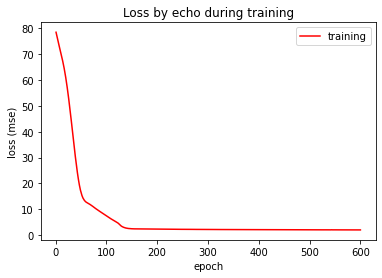

In [ ]:
# Plot fit history
fig, ax = plt.subplots()
ax.plot(range(1,epoch_n+1),loss_acc_fit_model_dnn_df['loss'],
        color="red",label="training")
ax.legend()
# Add title and axis names
ax.set_title('Loss by echo during training')
ax.set_xlabel('epoch')
ax.set_ylabel('loss (mse)')

# 6 Accuracy assessment and model comparioson

We will use the RMSE and MAE to assess model performance for both January and July predictions.



## 6.1. Quick comparison

Using the model fitted for January we quickly generate MAE to compare the Linear regression model and DNN.

In [ ]:
y_pred_train = model_lregr.predict(X) # Note this is a fit!
y_pred_test_lr = model_lregr.predict(X_testing_df) # Note this is a test!

y_pred_test_dnn = model_dnn.predict(X_testing_df) #predicted values!!!, need to compute the residuals
mae_val_test_dnn = metrics.mean_absolute_error(y_test, y_pred_test_dnn) #MAE

mae_val_test_lr = metrics.mean_absolute_error(y_test, y_pred_test_lr) #MAE

print('Regression MAE: ',mae_val_test_lr)
print('DNN MAE: ',mae_val_test_dnn)
print('Difference in MAE in percentage', (mae_val_test_lr-mae_val_test_dnn)*100/mae_val_test_lr)

2/2 [==============================] - 0s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Regression MAE:  1.079911327848354
DNN MAE:  0.945275830654881
Difference in MAE in percentage 12.467273351204186


## 6.2. Compare models and predict for July and January

To generate a full picture using training and testing data MAE and RMSEE for July and January using a pre-created function. To keep it simple we run it in  a loop using the model created earlier in the script.

In [ ]:
list_models =[model_lregr,model_dnn]
list_model_names = ['reg_ols','dnn']
list_data_metrics=[]
i = 0
for model in list_models:
  model_name = list_model_names[i]
  if model_name =='dnn':
    epoch_val = epoch_n
  else:
    epoch_val=None
  selected_features = ['LST1','ELEV_SRTM','DISTOC'] #selected features
  selected_target = ['T1'] #selected dependent variables

  metrics_jan_df = model_predict_assessement(model=model,
                                          data_df=avg_jan_df,
                                          selected_features = selected_features,
                                          selected_target = selected_target,
                                          prop=0.3,
                                          random_seed=random_seed,
                                          epoch_val=epoch_val,
                                          out_dir=out_dir)
  
  selected_features = ['LST7','ELEV_SRTM','DISTOC'] #selected features
  selected_target = ['T7'] #selected dependent variables

  metrics_jul_df = model_predict_assessement(model=model,
                                          data_df=avg_jul_df,
                                          selected_features = selected_features,
                                          selected_target = selected_target,
                                          prop=0.3,
                                          random_seed=random_seed,
                                          epoch_val=epoch_val,
                                          out_dir=out_dir
                                          )
  metrics_jan_df['month']='jan'
  metrics_jul_df['month']='jul'
  metrics_jan_df['model']=model_name
  metrics_jul_df['model']=model_name
  
  data_metrics = pd.concat([metrics_jan_df,metrics_jul_df])
  list_data_metrics.append(data_metrics)
  i=i+1

Epoch 1/600
4/4 [==============================] - 0s 3ms/step - loss: 2.0730 - mae: 1.0565
Epoch 2/600
1/4 [======>.......................] - ETA: 0s - loss: 1.9677 - mae: 0.9084

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


4/4 [==============================] - 0s 10ms/step - loss: 2.0729 - mae: 1.0563
Epoch 3/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0747 - mae: 1.0593
Epoch 4/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0755 - mae: 1.0568
Epoch 5/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0707 - mae: 1.0562
Epoch 6/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0701 - mae: 1.0559
Epoch 7/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0763 - mae: 1.0579
Epoch 8/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0775 - mae: 1.0595
Epoch 9/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0684 - mae: 1.0583
Epoch 10/600
4/4 [==============================] - 0s 5ms/step - loss: 2.0733 - mae: 1.0558
Epoch 11/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0743 - mae: 1.0555
Epoch 12/600
4/4 [==============================] - 0s 4ms/step - loss: 2.0712 - mae: 1.0

In [ ]:
#combine all
data_metrics = pd.concat(list_data_metrics)
display(data_metrics)

,mae,rmse,test,month,model
0,1.079911,1.403235,1,jan,reg_ols
1,1.138093,1.500918,0,jan,reg_ols
0,2.617082,3.372889,1,jul,reg_ols
1,2.022044,2.480021,0,jul,reg_ols
0,0.873550,1.249394,1,jan,dnn
1,1.011060,1.381902,0,jan,dnn
0,2.624722,3.366027,1,jul,dnn
1,2.035626,2.489668,0,jul,dnn


# 7 Conclusions

In this exercise, we predicted air temperature at stations located in Oregon using a dense neural network. We used several features including Land Surface Temperature from MODIS derived satellite imagery as well as the distance to ocean and elevation. We compared the dense neural network to a baseline model (Linear regression using OLS) for the month on January and July. Using the test data, we found a -0.20 C and 0.01 C difference in the MAE predicted temperatures in January and July respectively. From this short exercise, we can highlight a few interesting points:

1. **Improvements**: This is a modest improvement for the DNN for January. Improvements arising from Deep Neural Networks are often more visible when using more data and in more complext cases.

2. **Seasonality and error**: It is harder to predict in July than in January. A closer look at the temperature on the July LST layer will show more divergence in Summer compared to air temperature.

3. **Model complexity and architecture**: there is a trade off between model complexity and number of points available as well as the complexity of the problem. This is particularly true given that we only have 125 points for the fitting of the DNN model.

This exercise was a useful gentle introduction to DNN and keras but more interesting use cases will follow in the course!

In [ ]:
############################# END OF SCRIPT ###################################
